In [245]:
import numpy as np  
import pandas as pd  
from sklearn.preprocessing import MinMaxScaler  

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import LSTM  
from tensorflow.keras.layers import Dropout  
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import yfinance as yf
import talib

In [246]:
df = yf.download('AAPL', start = '2012-10-07', end = '2022-10-07')
df['Date'] = df.index

[*********************100%***********************]  1 of 1 completed


In [247]:
df['k'], df['d'] = talib.STOCH(df['High'], df['Low'], df['Close'], fastk_period=9, slowk_period=3, slowk_matype=1, slowd_period=3, slowd_matype=1)
df['ema_fast'] = df['Adj Close'].ewm(span=12).mean()
df['ema_slow'] = df['Adj Close'].ewm(span=26).mean()
df['macd'] = df.ema_fast - df.ema_slow
df['signal'] = df.macd.ewm(span=9).mean()
df['histograma'] = df.macd - df.signal

In [248]:
df = df[['Date', 'Adj Close', 'histograma', 'k', 'd']]

In [249]:
df = df.dropna()
df

Date   Adj Close  histograma          k          d
Date                                                               
2012-10-24 2012-10-24   18.890371   -0.041585  17.861644  22.087971
2012-10-25 2012-10-25   18.667118   -0.051114  13.153935  17.620953
2012-10-26 2012-10-26   18.497458   -0.061311  17.096453  17.358703
2012-10-31 2012-10-31   18.231632   -0.076089  14.401652  15.880178
2012-11-01 2012-11-01   18.268990   -0.078061  15.331800  15.605989
...               ...         ...         ...        ...        ...
2022-09-30 2022-09-30  138.199997   -1.329599  11.006005  18.204030
2022-10-03 2022-10-03  142.449997   -1.261773  16.809401  17.506715
2022-10-04 2022-10-04  146.100006   -0.891636  33.096433  25.301574
2022-10-05 2022-10-05  146.399994   -0.563178  42.120713  33.711143
2022-10-06 2022-10-06  145.429993   -0.357826  43.784933  38.748038

[2504 rows x 5 columns]

In [250]:
scaler = MinMaxScaler(feature_range = (0, 1))

In [251]:
df_train = df[ (df['Date'] >= '2014-09-17') & (df['Date'] <= '2020-05-29')]
df_val = df[ (df['Date'] >= '2020-06-01') & (df['Date'] <= '2020-09-18')]
df_test = df[ (df['Date'] >= '2020-09-19') & (df['Date'] <= '2020-12-04')]

print (df_train.shape)
print (df_val.shape)
print (df_test.shape)

(1435, 5)
(78, 5)
(54, 5)


In [252]:
time_steps = 60

def to_seq(df):
    df_sel = df.iloc[:, 1:5].values 
    df_scaled = scaler.fit_transform(df_sel)

    features_set = []  
    labels = []  
    for i in range(time_steps, len(df_scaled)):  
        features_set.append(df_scaled[i-time_steps:i])
        labels.append(df_scaled[i, 0])
    print(features_set)    
    features_set, labels = np.array(features_set), np.array(labels)  
    
    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 4))   
    return features_set,labels

In [253]:
x_train, y_train = to_seq(df_train)
x_val, y_val = to_seq(df_val)
print(x_train.shape)
print(x_val.shape)

[array([[0.03106328, 0.50488829, 0.7397467 , 0.69870077],
       [0.0318554 , 0.50697119, 0.77891329, 0.74085666],
       [0.02872513, 0.50392596, 0.73573652, 0.73932229],
       [0.02910233, 0.50216354, 0.67704382, 0.70781685],
       [0.03506092, 0.50819487, 0.79338453, 0.75299351],
       [0.03170444, 0.50732029, 0.73928585, 0.74724955],
       [0.01707174, 0.48827343, 0.36622987, 0.54900254],
       [0.02793314, 0.49030421, 0.46953771, 0.50398291],
       [0.02551945, 0.48912537, 0.45685282, 0.47482982],
       [0.02793314, 0.49199439, 0.51484918, 0.49062685],
       [0.02201224, 0.48702066, 0.38601612, 0.43105355],
       [0.02472755, 0.48808855, 0.39398093, 0.40543819],
       [0.02367153, 0.48829039, 0.36981521, 0.37997456],
       [0.02367153, 0.48929072, 0.36108348, 0.3626698 ],
       [0.02039053, 0.48674379, 0.30385412, 0.32404555],
       [0.02812176, 0.49573239, 0.54755985, 0.43236578],
       [0.0289514 , 0.50300811, 0.61592011, 0.52232719],
       [0.02785785, 0.50647559

In [254]:
model = Sequential()  
model.add(LSTM(units=96, return_sequences=True, input_shape=(time_steps, 4),unroll=False)) 
model.add(Dropout(0.2))  
model.add(LSTM(units=96, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=96, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=96))  
model.add(Dropout(0.2))  
model.add(Dense(units = 1))  
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 60, 96)            38784     
                                                                 
 dropout_20 (Dropout)        (None, 60, 96)            0         
                                                                 
 lstm_21 (LSTM)              (None, 60, 96)            74112     
                                                                 
 dropout_21 (Dropout)        (None, 60, 96)            0         
                                                                 
 lstm_22 (LSTM)              (None, 60, 96)            74112     
                                                                 
 dropout_22 (Dropout)        (None, 60, 96)            0         
                                                                 
 lstm_23 (LSTM)              (None, 96)               

In [255]:
def plot_loss_hist(hist):
    loss = hist.history['loss']
    vloss = hist.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, vloss, 'b', label='Validation loss')
    plt.title('Loss plot')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [256]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')  
history = model.fit(x_train, y_train, validation_data= (x_val, y_val),
                    epochs = 100, batch_size = 32)

Epoch 1/100
43/43 [==============================] - 9s 109ms/step - loss: 0.0169 - val_loss: 0.0444
Epoch 2/100
43/43 [==============================] - 4s 82ms/step - loss: 0.0035 - val_loss: 0.0404
Epoch 3/100
43/43 [==============================] - 4s 85ms/step - loss: 0.0024 - val_loss: 0.0372
Epoch 4/100
43/43 [==============================] - 4s 91ms/step - loss: 0.0023 - val_loss: 0.0385
Epoch 5/100
43/43 [==============================] - 4s 91ms/step - loss: 0.0027 - val_loss: 0.0373
Epoch 6/100
43/43 [==============================] - 4s 89ms/step - loss: 0.0020 - val_loss: 0.0366
Epoch 7/100
43/43 [==============================] - 4s 84ms/step - loss: 0.0019 - val_loss: 0.0353
Epoch 8/100
43/43 [==============================] - 4s 86ms/step - loss: 0.0019 - val_loss: 0.0321
Epoch 9/100
43/43 [==============================] - 4s 87ms/step - loss: 0.0019 - val_loss: 0.0377
Epoch 10/100
43/43 [==============================] - 4s 93ms/step - loss: 0.0019 - val_loss: 0.034

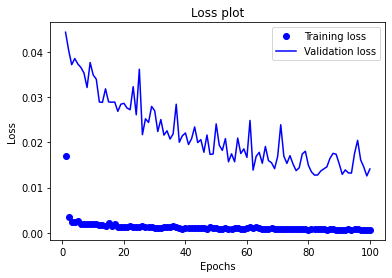

In [257]:
plot_loss_hist(history)

In [258]:
df_tst = pd.concat((df_val, df_test), axis=0)  
df_tst

Date   Adj Close  histograma          k          d
Date                                                               
2020-06-01 2020-06-01   79.359703   -0.128878  71.919762  71.416172
2020-06-02 2020-06-02   79.727097   -0.115191  81.924032  76.670102
2020-06-03 2020-06-03   80.165985   -0.094713  86.842962  81.756532
2020-06-04 2020-06-04   79.475594   -0.142904  78.623616  80.190074
2020-06-05 2020-06-05   81.739143   -0.042771  88.641926  84.416000
...               ...         ...         ...        ...        ...
2020-11-30 2020-11-30  117.832985   -0.077893  59.191941  48.789136
2020-12-01 2020-12-01  121.465462    0.271273  76.149281  62.469209
2020-12-02 2020-12-02  121.821785    0.493825  86.282365  74.375787
2020-12-03 2020-12-03  121.683212    0.592643  89.387848  81.881818
2020-12-04 2020-12-04  121.000259    0.572635  87.857470  84.869644

[132 rows x 5 columns]

In [259]:
df_tst2 = scaler.fit_transform(df_tst[['Adj Close', 'histograma', 'k', 'd']])

In [260]:
test_features = []  
for i in range(60, len(df_tst2)+1):  
    test_features.append(df_tst2[i-60:i])

test_features = np.array(test_features)   
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 4)) 
test_features.shape

(73, 60, 4)

In [261]:
pred = model.predict(test_features)  
print(pred.shape)
scaler.fit(df_tst.iloc[:, [1]]) 

(73, 1)


MinMaxScaler()

In [262]:
pred = scaler.inverse_transform(pred) 
pred_df = pd.DataFrame(pred, columns =['Predict']) 

In [300]:
df_tst1 = df_tst.iloc[60:len(df_tst), 0:2]
next_date = df_tst.iloc[len(df_tst)-1:len(df_tst), 0] + pd.to_timedelta(1,unit='d')
df_tst1.loc[len(df_tst1.index)] = [next_date.values[0], 0]  
df_tst1

Date   Adj Close
Date                                      
2020-08-25 00:00:00 2020-08-25  123.336166
2020-08-26 00:00:00 2020-08-26  125.013412
2020-08-27 00:00:00 2020-08-27  123.518951
2020-08-28 00:00:00 2020-08-28  123.318878
2020-08-31 00:00:00 2020-08-31  127.500900
...                        ...         ...
2020-12-01 00:00:00 2020-12-01  121.465462
2020-12-02 00:00:00 2020-12-02  121.821785
2020-12-03 00:00:00 2020-12-03  121.683212
2020-12-04 00:00:00 2020-12-04  121.000259
72                  2020-12-05    0.000000

[73 rows x 2 columns]

In [301]:
df_tst2 = pd.DataFrame({'Actual' : df_tst1['Adj Close'].values,
                       'Predict' : pred_df.values.flatten()}, index = df_tst1['Date'])
df_tst2

Actual     Predict
Date                              
2020-08-25  123.336166  118.625237
2020-08-26  125.013412  120.149261
2020-08-27  123.518951  121.634842
2020-08-28  123.318878  122.497292
2020-08-31  127.500900  122.946388
...                ...         ...
2020-12-01  121.465462  116.992264
2020-12-02  121.821785  118.762856
2020-12-03  121.683212  120.290092
2020-12-04  121.000259  121.125679
2020-12-05    0.000000  121.422600

[73 rows x 2 columns]

In [307]:
df_tst2 = df_tst2.drop('2020-12-05')

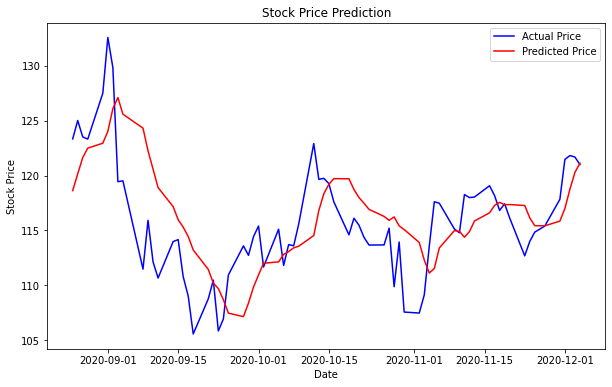

In [315]:
plt.figure(figsize=(10,6))  
plt.plot(df_tst2.index, df_tst2['Actual'], 'b', label='Actual Price')  
plt.plot(df_tst2.index, df_tst2['Predict'], 'r', label='Predicted Price')  
plt.title('Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Stock Price')  
plt.legend()  
plt.show()

In [318]:
testScore = mean_squared_error(df_tst2['Actual'], 
                               df_tst2['Predict'], squared=False)
print("Test Score: %.2f RMSE" % (testScore))

Test Score: 4.31 RMSE
